In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = "../backtest/new_data/prices_round_1_day_0.csv"

df = pd.read_csv(path, delimiter=';')
df_a = df[df['product'] == 'AMETHYSTS']
df_s = df[df['product'] == 'STARFRUIT']

df_s.head()

# pairs price, timestamp
s_bid = df_s[['bid_price_1', 'timestamp']]
s_ask = df_s[['ask_price_1', 'timestamp']]


In [3]:
n_forward = 20

# mark as good these bids that could be sold later

margin = 1

good_bids = []
for t in range(len(s_bid)-n_forward):
    for forw in range(1, n_forward):
        if s_bid['bid_price_1'].values[t] > s_ask['ask_price_1'].values[t+forw]+ margin:
            # print(f'sell at {s_bid["bid_price_1"].values[t]}, time {s_bid["timestamp"].values[t]}')
            # print(f'buy at {s_ask["ask_price_1"].values[t+forw]}, time {s_ask["timestamp"].values[t+forw]} (+{forw})')
            good_bids.append(s_bid['timestamp'].values[t])
            break
           
print(len(good_bids))
print(len(good_bids) / len(s_bid))

good_asks = []
for t in range(len(s_ask)-n_forward):
    for forw in range(1, n_forward):
        if s_ask['ask_price_1'].values[t] < s_bid['bid_price_1'].values[t+forw] - margin:
            # print(f'buy at {s_ask["ask_price_1"].values[t]}, time {s_ask["timestamp"].values[t]}')
            # print(f'sell at {s_bid["bid_price_1"].values[t+forw]}, time {s_bid["timestamp"].values[t+forw]} (+{forw})')
            # print("---")
            good_asks.append(s_ask['timestamp'].values[t])
            break
            
print(len(good_asks))
print(len(good_asks) / len(s_ask))


1122
0.1122
1100
0.11


In [5]:
# now create a collumn in the dataframe that marks the good bids and asks
df_s['good_bid'] = df_s['timestamp'].apply(lambda x: x in good_bids)
df_s['good_ask'] = df_s['timestamp'].apply(lambda x: x in good_asks)

/tmp/ipykernel_7024/1599113307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s['good_bid'] = df_s['timestamp'].apply(lambda x: x in good_bids)
/tmp/ipykernel_7024/1599113307.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s['good_ask'] = df_s['timestamp'].apply(lambda x: x in good_asks)


In [6]:
df_s = df_s.fillna(0)

In [12]:
n_prev = 5
# 
# colls_taken = ['bid_price_1', 'bid_volume_1', 'ask_price_1', 'ask_volume_1', 'bid_price_2', 'bid_volume_2', 'ask_price_2', 'ask_volume_2', 'bid_price_3', 'bid_volume_3',
#                'ask_price_3', 'ask_volume_3']

colls_taken = ['bid_price_1', 'bid_volume_1', 'ask_price_1', 'ask_volume_1', 'bid_volume_2', 'ask_volume_2']

X = []
Y_bid = df_s['good_bid'].values[n_prev:]
Y_ask = df_s['good_ask'].values[n_prev:]

for i in range(n_prev, len(df_s)):
    X.append(df_s[colls_taken][i-n_prev:i])
    
X = np.array(X)
X = X.reshape(X.shape[0], -1)
Y_bid = np.array(Y_bid)
Y_ask = np.array(Y_ask)

print(X.shape, Y_bid.shape, Y_ask.shape)

(9995, 30) (9995,) (9995,)


In [13]:
# create a NN model using torch

import torch

X = torch.tensor(X, dtype=torch.float32)
Y_bid = torch.tensor(Y_bid, dtype=torch.float32)

model_bid = torch.nn.Sequential(
    torch.nn.BatchNorm1d(X.shape[1]),
    torch.nn.Linear(X.shape[1], 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
    # torch.nn.BatchNorm1d(1),
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()
# loss_fn = torch.nn.MSELoss()

print(model_bid.parameters)

optimizer = torch.optim.Adam(model_bid.parameters(), lr=0.01)

<bound method Module.parameters of Sequential(
  (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=30, out_features=100, bias=True)
  (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
  (5): Sigmoid()
)>


In [14]:
for i in range(1000):
    optimizer.zero_grad()
    pred = model(X)
    # print(pred.reshape(-1).shape)
    # print(Y.shape)
    loss = loss_fn(pred.reshape(-1), Y_bid)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(loss.item())
        
model_bid.eval()

0.18037161231040955
0.18037161231040955
0.18037161231040955
0.18037161231040955
0.18037161231040955
0.18037161231040955
0.18037161231040955
0.18037161231040955
0.18037161231040955
0.18037161231040955


Sequential(
  (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=30, out_features=100, bias=True)
  (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
  (5): Sigmoid()
)

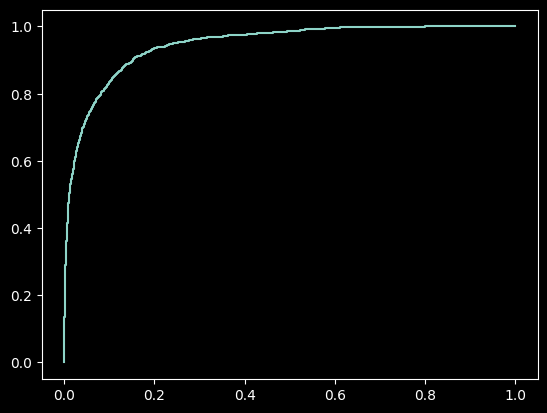

In [11]:
# get the roc curve
from sklearn.metrics import roc_curve, roc_auc_score

pred = model_bid(X).detach().numpy().reshape(-1)
fpr, tpr, _ = roc_curve(Y_bid, pred)
plt.plot(fpr, tpr)
plt.show()

In [15]:
# save the model

torch.save(model_bid, 'model_bid.pt')

In [18]:

X = torch.tensor(X, dtype=torch.float32)
Y_ask = torch.tensor(Y_ask, dtype=torch.float32)

model_ask = torch.nn.Sequential(
    torch.nn.BatchNorm1d(X.shape[1]),
    torch.nn.Linear(X.shape[1], 100),
    torch.nn.BatchNorm1d(100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
    # torch.nn.BatchNorm1d(1),
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()
# loss_fn = torch.nn.MSELoss()

print(model_ask.parameters)

optimizer = torch.optim.Adam(model_ask.parameters(), lr=0.01)
    

<bound method Module.parameters of Sequential(
  (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=30, out_features=100, bias=True)
  (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
  (5): Sigmoid()
)>


/tmp/ipykernel_7024/2712900320.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_7024/2712900320.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_ask = torch.tensor(Y_ask, dtype=torch.float32)


In [20]:
for i in range(1000):
    optimizer.zero_grad()
    pred = model_ask(X)
    # print(pred.reshape(-1).shape)
    # print(Y.shape)
    loss = loss_fn(pred.reshape(-1), Y_ask)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(loss.item())
        
model_ask.eval()

0.6341652274131775
0.33131134510040283
0.3073897659778595
0.2759629189968109
0.2464950680732727
0.22188618779182434
0.26047366857528687
0.2015402913093567
0.18907779455184937
0.17938373982906342


Sequential(
  (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=30, out_features=100, bias=True)
  (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=1, bias=True)
  (5): Sigmoid()
)

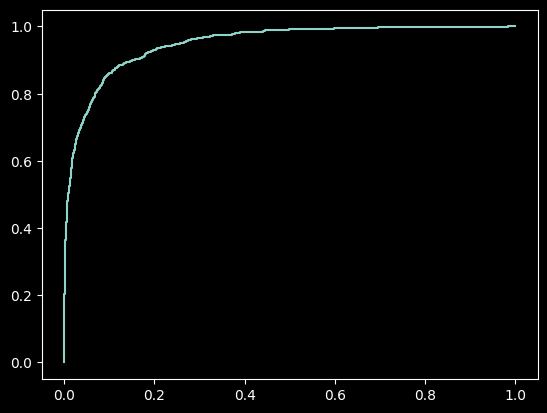

0.949988208393573


In [21]:
# get the roc curve

pred = model_ask(X).detach().numpy().reshape(-1)

fpr, tpr, _ = roc_curve(Y_ask, pred)
plt.plot(fpr, tpr)
plt.show()

# roc auc score
print(roc_auc_score(Y_ask, pred))

# save the model

torch.save(model_ask, 'model_ask.pt')